# Text spatialization

This notebook demonstrates an example of how to embed and predict text samples using large language models (LLMs) and prepare them for 2D visualization using dimension reduction.

# Prepare data

## Load dataset

We load the dataset from two alternative sources:

1. From file (download BANKING77, HWU64, CLINC150 from https://github.com/alexa/dialoglue)
2. From HuggingFace (see available datasets from https://huggingface.co/datasets)

In this example, we load BANKING77 from HuggingFace Datasets.

In [1]:
from datasets import load_dataset

dataset = "banking77"
raw_datasets = load_dataset(dataset)

Using custom data configuration default
Reusing dataset banking77 (/home/mojo/.cache/huggingface/datasets/banking77/default/1.1.0/aec0289529599d4572d76ab00c8944cb84f88410ad0c9e7da26189d31f62a55b)


In [2]:
target_dataset = raw_datasets["test"]
label_map = None
target_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 3080
})

In [3]:
# see an example data instance
target_dataset[10]

{'text': 'How do I track my card?', 'label': 11}

## Label-encoding

Since some datasets have encoded numeric labels and some do not, we use label-encoding in any case to normalize the datasets.

In [4]:
# Label encode the labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(target_dataset["label"])

def label_encode_fn(examples):
    encoded_labels = list(le.transform([examples["label"]]))
    return {"label": encoded_labels[0]}
    
target_dataset = target_dataset.map(label_encode_fn, batched=False)

Loading cached processed dataset at /home/mojo/.cache/huggingface/datasets/banking77/default/1.1.0/aec0289529599d4572d76ab00c8944cb84f88410ad0c9e7da26189d31f62a55b/cache-bfeeac043f5223b2.arrow


In [5]:
# map from each label to the indices of the corresponding data samples
from collections import defaultdict
label_to_indices = defaultdict(list)

for i, label in enumerate(target_dataset["label"]):
    label_to_indices[label].append(i)

In [6]:
# sanity check
for label in label_to_indices:
    indices = label_to_indices[label]
    assert not any(lbl != label for lbl in target_dataset[indices]["label"])

## Embed

Embedding is simple. We embed data samples using both encoder LMs (BERT-like) and decoder LMs (GPT-like) using HuggingFace and OpenAI API respectively. With HuggingFace, you can easily load your own models or models from the HuggingFace Hub (https://huggingface.co/models).

For this example, we use an off-the-shelf model (https://huggingface.co/philschmid/BERT-Banking77)

### Load model

In [7]:
model_name = "philschmid/BERT-Banking77"

In [8]:
# initialize model

if model_name == "gpt-3":
    import openai
    model_name = "text-embedding-ada-002"
else:
    from transformers import AutoTokenizer, AutoModel
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    
print("Loaded model", model_name)

Some weights of the model checkpoint at philschmid/BERT-Banking77 were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded model philschmid/BERT-Banking77


### Define the function for embedding a given text sample

In [9]:
import torch

def embed(text, model_name):
    if model_name == "gpt-3":
        text = text.replace("\n", " ")
        return openai.Embedding.create(input = [text], model=model_name)['data'][0]['embedding']
    else:
        with torch.no_grad():
            tokenized_inputs = tokenizer(text, return_tensors="pt")
            model_output = model(**tokenized_inputs)
            return model_output.last_hidden_state.squeeze()[0].tolist()

### Embed all samples in the dataset

In [10]:
encodings = []

In [11]:
from tqdm.auto import tqdm

texts = target_dataset["text"]
num_tokens = [len(txt.split(" ")) for txt in texts]
num_tokens_in_K = (1.33 * sum(num_tokens)) / 1000
PRICE = 0.0004 # $ per 1000 tokens
price_estimate = "{:.2f}".format(PRICE * num_tokens_in_K)

if model_name == "gpt-3":
    if input(f"The price estimate for {dataset} is {price_estimate}$ with {model_name}. Confirm run? [Yes/No] ") == "Yes":
        for text in tqdm(texts):
            embedding = embed(text, model_name)
            encodings.append(embedding)
else: 
    for text in tqdm(texts):
            embedding = embed(text, model_name)
            encodings.append(embedding)

  0%|          | 0/3080 [00:00<?, ?it/s]

In [12]:
len(encodings)

3080

### Save the encodings to file

In [13]:
import json
import os

model_name_short = model_name.split("/")[-1]
dataset_name_short = dataset.split("/")[-1]
output_dir = f"results/{dataset_name_short}-with-{model_name_short}"
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)
print(output_dir)

results/banking77-with-BERT-Banking77


In [14]:
import json
import os

with open(f"{output_dir}/encodings.json", "w") as f:
    json.dump(list(encodings), f)

Load back from file to check

In [15]:
import numpy as np
import json

model_name_short = model_name.split("/")[-1]
dataset_name_short = dataset.split("/")[-1]
output_dir = f"results/{dataset_name_short}-with-{model_name_short}"
with open(f"{output_dir}/encodings.json", "r") as f:
    encodings = json.load(f)
encodings = np.array(encodings)

In [16]:
output_dir

'results/banking77-with-BERT-Banking77'

In [17]:
encodings.shape

(3080, 768)

## Few-shot classification

### Define the prediction function

In [18]:
import random


random.seed(0)

def sample_query_and_support_sets(n, k, m):
    """
    Direct quote: 

    In an episode of a n-way k-shot text classification problem, n classes are sampled from corresponding class set
    (Chen et al. 2022)


    Direct quote:
    ...for each of the n classes, k labeled texts are sampled to compose the support set, and m unlabeled texts
    are sampled to compose the query set.
    (Chen et al. 2022)
    """
    query_set = []
    support_set = []
    n_classes = random.sample(set(target_dataset["label"]), n)
    
    for label in n_classes:
        indices = label_to_indices[label].copy()
        samples = random.sample(indices, k + m)
        support_set_for_label = samples[:k]
        support_set += support_set_for_label
        query_set += samples[k:]

    return query_set, support_set

In [19]:
def sample_support_set(n, k, must_have):
    support_set = []
    all_classes_except_must_have = [i for i in range(len(le.classes_)) if i != must_have]
    n_classes = [must_have] + random.sample(all_classes_except_must_have, n-1)

    for label in n_classes:
        indices = label_to_indices[label].copy()
        support_set_for_label = random.sample(indices, k)
        support_set += support_set_for_label
    return support_set

In [20]:
support_set = sample_support_set(5, 1, 2)
support_set

[2992, 2271, 905, 1059, 190]

In [21]:
sample_query_and_support_sets(2, 5, 2)

([1606, 1616, 1164, 1181],
 [1613, 1632, 1608, 1618, 1637, 1194, 1198, 1169, 1179, 1166])

In [22]:
# Then, a method to get the cached encodings
def get_encodings(idxs, encoding_type="cls"):
    return encodings[idxs]

In [23]:
"""
How to make a prediction:

Specifically, given a query text xq ∈ Q, we first obtain its representation f(xq) and representations 
of all texts in the support set {f(xs)}, then the label of query text xq is determined as the label of the
support-text whose representation f(xs) has the maximum inner product with f(xq).
"""

def predict(q, s_set):
    xs_set = get_encodings(s_set)
    xq_set = get_encodings([q])
    
    distances = np.inner(xq_set, xs_set)
    nn_idx = s_set[np.argmax(distances)]
    label = target_dataset["label"][nn_idx]
    target_dataset[q]["prediction"] = label
    return label, distances.tolist()

In [24]:
label, distances = predict(0, support_set)
label, distances

(6,
 [[-9.111044696388465,
   15.501294235610938,
   14.762332633208318,
   28.9683928354836,
   -16.373702992470072]])

### Predict all examples and save the results in format for SemLa

In [25]:
from tqdm.auto import tqdm
n = 5
k = 1


results = []

for i in tqdm(range(len((target_dataset)))):
    example = target_dataset[i]
    ground_truth = example["label"]
    support_set = sample_support_set(n, k, example["label"])
    prediction, distances = predict(i, support_set)
    
    result_entry = {
        "idx": i,
        "text": example["text"],
        "support_set": support_set,
        "distances": distances,
        "prediction_label_idx": prediction, 
        "ground_truth_label_idx": ground_truth, 
    }

    results.append(result_entry)

  0%|          | 0/3080 [00:00<?, ?it/s]

In [26]:
predictions = [res["prediction_label_idx"] for res in results]
labels = [res["ground_truth_label_idx"] for res in results]

In [27]:
[(predictions[i], labels[i]) for i in range(len(predictions))]

[(11, 11),
 (11, 11),
 (11, 11),
 (11, 11),
 (11, 11),
 (11, 11),
 (11, 11),
 (11, 11),
 (11, 11),
 (11, 11),
 (11, 11),
 (11, 11),
 (11, 11),
 (11, 11),
 (11, 11),
 (11, 11),
 (11, 11),
 (11, 11),
 (11, 11),
 (11, 11),
 (11, 11),
 (40, 11),
 (11, 11),
 (11, 11),
 (11, 11),
 (11, 11),
 (11, 11),
 (11, 11),
 (11, 11),
 (11, 11),
 (11, 11),
 (11, 11),
 (12, 11),
 (11, 11),
 (11, 11),
 (11, 11),
 (11, 11),
 (12, 11),
 (11, 11),
 (11, 11),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (13, 13),
 (32, 32),
 (32, 32),
 (32, 32),
 (32, 32),
 (32, 32),
 (32, 32),
 (32, 32),
 (32, 32),
 (32, 32),
 (32, 32),
 (32, 32),

In [28]:
from sklearn.metrics import accuracy_score, f1_score

acc = accuracy_score(predictions, labels)
f1 = f1_score(predictions, labels, average="weighted")
acc, f1

(0.9818181818181818, 0.9820835100024049)

In [29]:
output_dir

'results/banking77-with-BERT-Banking77'

In [30]:
import json

with open(f"{output_dir}/performance.json", "w") as f:
    json.dump(dict(
        accuracy=acc,
        f1=f1,
        n_way=n,
        k_shot=k,
    ), f)

## Text spatialization with dimension reduction

### UMAP

In [31]:
from numba import jit

In [32]:
@jit
def inner_product_distance(a,b, tau=15):
    return np.exp(-np.sum(a * b) / tau)**2

In [33]:
encodings.shape

(3080, 768)

In [34]:
from umap import UMAP

umap_2d = UMAP(n_components=2, metric=inner_product_distance)
umap_results_cls = umap_2d.fit_transform(encodings)

/home/mojo/anaconda3/envs/dialoglue/lib/python3.6/site-packages/umap/umap_.py:1728: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "
/home/mojo/anaconda3/envs/dialoglue/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [35]:
num_labels = len(le.classes_)
num_labels

77

In [36]:
prediction_idxs = [res["prediction_label_idx"] for res in results]

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


df = pd.DataFrame()
df['cls-umap-2d-one'] = umap_results_cls[:,0]
df['cls-umap-2d-two'] = umap_results_cls[:,1]
df['y'] = prediction_idxs

plt.figure(figsize=(20,10))
scatter_plot = sns.scatterplot(
    x="cls-umap-2d-one", y="cls-umap-2d-two",
    hue="y",
    palette=sns.color_palette("hls", num_labels),
    data=df,
    legend=False,
    alpha=0.3,
)


In [38]:
fig = scatter_plot.get_figure()
fig.savefig(f"{output_dir}/embedding_space-umap.png")

In [39]:
umap_data_dicts = [{"umap-dim0": d[0].item(), "umap-dim1": d[1].item()} for d in umap_results_cls]

In [40]:
for i in range(len(results)):
    umap_entries = umap_data_dicts[i]
    results[i].update(umap_entries)

### t-SNE

In [41]:
def inner_product_distance_np(a,b, tau=15):
    return np.exp(-np.inner(a,b) / tau)

In [42]:
import time
from sklearn.manifold import TSNE


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000, metric=inner_product_distance_np)
tsne_results = tsne.fit_transform(encodings)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/home/mojo/.local/lib/python3.6/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3080 samples in 0.001s...
[t-SNE] Computed neighbors for 3080 samples in 17.550s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3080
[t-SNE] Computed conditional probabilities for sample 2000 / 3080
[t-SNE] Computed conditional probabilities for sample 3000 / 3080
[t-SNE] Computed conditional probabilities for sample 3080 / 3080
[t-SNE] Mean sigma: 0.000253
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.209435
[t-SNE] KL divergence after 1000 iterations: 0.207744
t-SNE done! Time elapsed: 22.01372218132019 seconds


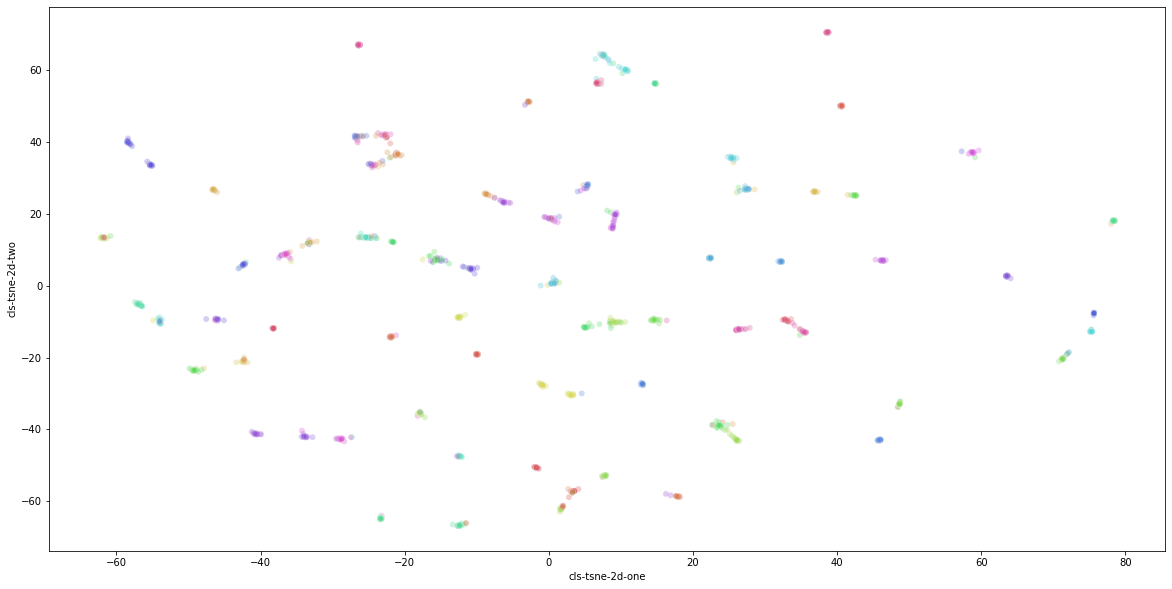

In [43]:
df['cls-tsne-2d-one'] = tsne_results[:,0]
df['cls-tsne-2d-two'] = tsne_results[:,1]
df['y'] = prediction_idxs

plt.figure(figsize=(20,10))
sns.scatterplot(
    x="cls-tsne-2d-one", y="cls-tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", num_labels),
    data=df,
    legend=False,
    alpha=0.3,
)

plt.savefig(f"{output_dir}/embedding_space-tsne.png")

In [44]:
tsne_data_dicts = [{"tsne-dim0": d[0].item(), "tsne-dim1": d[1].item()} for d in tsne_results]

In [45]:
for i in range(len(results)):
    tsne_entries = tsne_data_dicts[i]
    results[i].update(tsne_entries)

### Assign higher-level clusters for color encoding

In [46]:
def inner_product_distance_torch(a,b, tau=15):
    return torch.exp(-torch.inner(a,b) / tau)

In [47]:
import random

class KMeans:
    def __init__(self, num_clusters, distance_metric, max_iter=1000, random_seed=0):
        self.num_clusters = num_clusters
        self.distance_metric = distance_metric
        self.max_iter = max_iter
        self.centroids = []
        
    def fit(self, X):
        with torch.no_grad():
            # initialise centroids
            centroids_idxs = random.sample(range(X.shape[0]), self.num_clusters)
            self.centroids = X[centroids_idxs]

            converged = False

            previous_clusters = None

            iter_count = 0
            while iter_count < self.max_iter and not converged:
                clusters = []
                # for each example, find which cluster mean they are closest to
                for x in X:
                    distances = self.distance_metric(x, self.centroids)
                    cluster = torch.argmin(distances).item()
                    clusters.append(cluster)

                clusters = torch.tensor(clusters, device="cuda")
                if previous_clusters is not None and all(clusters == previous_clusters):
                    converged = True

                # update the cluster means
                for i in range(self.num_clusters):
                    self.centroids[i] = X[(clusters == i).nonzero().squeeze()].mean(dim=0)
                previous_clusters = clusters

                print("Iteration:", iter_count)
                iter_count += 1
            return clusters

In [48]:
NUM_CLUSTERS = 12

kmeans = KMeans(NUM_CLUSTERS, distance_metric=inner_product_distance_torch)

In [49]:
import torch

In [50]:
encodings_torch = torch.tensor(encodings, device="cuda")
encodings_torch

tensor([[ 0.4599, -0.6121,  0.0485,  ..., -0.9381, -0.4580, -0.5850],
        [ 0.1936,  0.1418,  1.3138,  ..., -0.5118,  0.0656, -0.7725],
        [ 0.2229, -0.1873,  1.4307,  ..., -0.3323, -0.0557, -0.4687],
        ...,
        [ 0.3438, -0.4746,  0.1217,  ...,  0.2248, -0.1163, -0.2752],
        [ 0.4043, -0.6214,  0.1972,  ...,  0.2564, -0.2064, -0.2723],
        [ 0.3461, -0.5868,  0.1187,  ...,  0.3150, -0.1642, -0.1863]],
       device='cuda:0', dtype=torch.float64)

In [51]:
if len(le.classes_) < NUM_CLUSTERS:
    assigned_clusters = prediction_idxs
else:
    assigned_clusters = kmeans.fit(encodings_torch).cpu().tolist()

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15


In [52]:
all([assigned_clusters[i] == prediction_idxs[i] for i in range(len(assigned_clusters))])

False

In [53]:
len(set(assigned_clusters))

12

Find which cluster each label group belongs to based on majority vote of the group's members

In [54]:
# First, group examples by label
from collections import defaultdict
from tqdm.auto import tqdm


label_groups = defaultdict(list)

for i in tqdm(range(len(target_dataset))):
    example = raw_datasets["test"][i]
    label = results[i]["prediction_label_idx"]
    label_groups[label].append(i)

  0%|          | 0/3080 [00:00<?, ?it/s]

In [55]:
from collections import Counter

# Now, map each label group to the clusters they belong to
label_to_clusters = {label: [assigned_clusters[idx] for idx in group] 
                        for label, group in label_groups.items()}

label_to_cluster = dict()
# Then, map the cluster list to count of different clusters
for label, clusters in label_to_clusters.items():
    counts = Counter(clusters)
    value, count = counts.most_common()[0]
    label_to_cluster[label] = value

label_to_cluster

{11: 0,
 40: 8,
 12: 6,
 13: 9,
 32: 11,
 31: 10,
 17: 11,
 64: 10,
 34: 4,
 46: 7,
 36: 0,
 55: 3,
 4: 1,
 1: 10,
 14: 8,
 33: 9,
 41: 2,
 24: 10,
 49: 6,
 22: 2,
 23: 8,
 56: 10,
 59: 6,
 47: 4,
 8: 0,
 53: 5,
 60: 6,
 75: 4,
 27: 4,
 76: 11,
 15: 5,
 66: 0,
 67: 7,
 54: 9,
 72: 8,
 10: 5,
 61: 3,
 25: 5,
 57: 6,
 6: 4,
 16: 2,
 30: 3,
 74: 7,
 68: 7,
 38: 6,
 73: 5,
 9: 5,
 65: 9,
 62: 6,
 42: 1,
 29: 8,
 3: 11,
 28: 0,
 44: 9,
 26: 11,
 45: 5,
 52: 8,
 50: 10,
 7: 10,
 51: 4,
 48: 7,
 18: 11,
 63: 5,
 70: 7,
 5: 7,
 21: 3,
 35: 0,
 71: 1,
 39: 9,
 58: 11,
 43: 5,
 37: 8,
 20: 2,
 0: 9,
 19: 11,
 2: 1,
 69: 7}

In [56]:
if len(le.classes_) < NUM_CLUSTERS:
    label_clusters = assigned_clusters
else:
    label_clusters = [label_to_cluster[label] for label in prediction_idxs]
    
len(label_clusters), len(assigned_clusters), len(results)

(3080, 3080, 3080)

In [57]:
from collections import defaultdict

cluster_to_labels = defaultdict(set)
for label, clusters in label_to_clusters.items():
    for cluster in clusters:
        cluster_to_labels[cluster].add(label)

[len(s) for s in cluster_to_labels.values()]

[18, 23, 19, 13, 20, 14, 17, 14, 16, 21, 13, 9]

In [58]:
for i in range(len(results)):
    results[i].update(dict(label_cluster=label_clusters[i], instance_cluster=assigned_clusters[i]))

### Save data

In [61]:
import json

label_grouping = "predicted"
# model_type = "gpt"
fname = output_dir + "/" + dataset_name_short + "-viz_data-" + str(NUM_CLUSTERS) + "-clusters-label_cluster_chosen_by_majority_in-" + label_grouping + "-label-with-" + model_name_short + ".json"

with open(fname, "w") as f:
    json.dump(results, f)
    print("Saved to", fname)

Saved to results/banking77-with-BERT-Banking77/banking77-viz_data-12-clusters-label_cluster_chosen_by_majority_in-predicted-label-with-BERT-Banking77.json
